In [1]:
import matplotlib.pyplot as plt
import os

import pandas
import numpy
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb
import pyAgrum.lib.bn2graph as bnPlot
import pyAgrum.lib.dynamicBN as gdyn

# Diabetes Remission Bayesian Networks

## Create network

In [20]:
bn=gum.BayesNet('Diabetes Remission')
print(bn)

BN{nodes: 0, arcs: 0, domainSize: 1, dim: 0}


In [21]:
G = bn.add(gum.LabelizedVariable('Glycemia','superior to 6.5 ?',2))
I = bn.add(gum.LabelizedVariable('Insulin','Insulin taken ?',2))
O = bn.add(gum.LabelizedVariable('Other_drugs','Other drugs taken ?',2))
R = bn.add(gum.LabelizedVariable('Remission','Remission or not ?',2))
print(bn)

BN{nodes: 4, arcs: 0, domainSize: 16, dim: 8}


In [24]:
for link in [(G, I),(G, O),(O, R),(I, R)]:
    bn.addArc(*link)
print(bn)

BN{nodes: 4, arcs: 4, domainSize: 16, dim: 18}


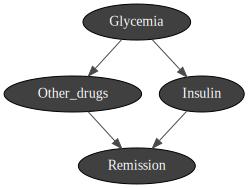

In [25]:
gnb.show(bn)

In [26]:
print(bn)

BN{nodes: 4, arcs: 4, domainSize: 16, dim: 18}


##  Value initialisation

In [27]:
bn.cpt(G).fillWith([0.5,0.5])
bn.cpt('Insulin')[:] = [[0.9, 0.1], [0.1, 0.9]]
bn.cpt('Other_drugs')[:] = [[0.75, 0.25], [0.3, 0.7]]
bn.cpt('Remission')[0, 0, :] = [0.1, 0.9]
bn.cpt('Remission')[{'Insulin': 1, 'Other_drugs': 0}] = [0.6, 0.4]
bn.cpt('Remission')[{'Insulin': 0, 'Other_drugs': 1}] = [0.3, 0.7]
bn.cpt('Remission')[{'Insulin': 1, 'Other_drugs': 1}] = [0.9, 0.1]

In [28]:
bn.cpt(G)

(pyAgrum.Potential<double>@0x55e2279c7200) 
  Glycemia         |
0        |1        |
---------|---------|
 0.5000  | 0.5000  |

In [29]:
bn.cpt('Insulin')

(pyAgrum.Potential<double>@0x55e2278bea00) 
      ||  Insulin          |
Glycem||0        |1        |
------||---------|---------|
0     || 0.9000  | 0.1000  |
1     || 0.1000  | 0.9000  |

In [30]:
bn.cpt('Other_drugs')

(pyAgrum.Potential<double>@0x55e2279aeb60) 
      ||  Other_drugs      |
Glycem||0        |1        |
------||---------|---------|
0     || 0.7500  | 0.2500  |
1     || 0.3000  | 0.7000  |

In [31]:
bn.cpt('Remission')

(pyAgrum.Potential<double>@0x55e227a0ad00) 
             ||  Remission        |
Other_|Insuli||0        |1        |
------|------||---------|---------|
0     |0     || 0.1000  | 0.9000  |
1     |0     || 0.3000  | 0.7000  |
0     |1     || 0.6000  | 0.4000  |
1     |1     || 0.9000  | 0.1000  |

## Perform inference

In [36]:
ie=gum.LazyPropagation(bn)

In [34]:
ie.posterior('Remission')

(pyAgrum.Potential<double>@0x55e22750fea0) 
  Remission        |
0        |1        |
---------|---------|
 0.4778  | 0.5223  |

## Inference with evidence

In [42]:
ie.setEvidence({'Glycemia': 1, 'Other_drugs': 1})
ie.makeInference()
ie.posterior("Remission")

(pyAgrum.Potential<double>@0x55e227c9b270) 
  Remission        |
0        |1        |
---------|---------|
 0.8400  | 0.1600  |

In [43]:
ie.setEvidence({'Glycemia': 0, 'Insulin': 0})
ie.makeInference()
ie.posterior("Remission")

(pyAgrum.Potential<double>@0x55e2275c0bd0) 
  Remission        |
0        |1        |
---------|---------|
 0.1500  | 0.8500  |

It seems that 

if the glycemia level is less than 6.5 and no drugs are taken, the regmission is true with a probability of 0.84.

if the glycemia level is bigger than 6.5 and insulin is prescribed the regmission is true with a probability of 0.15.


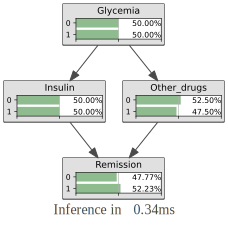

In [41]:
gnb.showInference(bn,evs={})


# 2. Construct Bayesian networks from real data

# Reference
http://www-desir.lip6.fr/~phw/aGrUM/docs/last/notebooks/01-tutorial.ipynb.html